In [2]:
# import timm
import torch.optim as optim
import torch.nn as nn
# model = timm.create_model('resnet18', in_chans=1, num_classes=1).float().to("mps")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, (nf, 4), padding="same")
        self.conv2 = nn.Conv2d(4, 8, (nf, 4), padding="same")
        self.conv3 = nn.Conv2d(8, 16, (nf, 4), padding="same")
        self.conv4 = nn.Conv2d(16, 32, (nf, 4), padding="valid")
        
        self.pool = nn.MaxPool2d((1, 2), (1, 2))
        self.fc1 = nn.Linear(32, 1)
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu((self.conv2(x))))
        x = self.pool(F.relu((self.conv3(x))))
        x = F.relu((self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x
model = Net(7).to("cuda")
print(summary(model, (1, 7, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 4, 7, 32]             116
         MaxPool2d-2             [-1, 4, 7, 16]               0
            Conv2d-3             [-1, 8, 7, 16]             904
         MaxPool2d-4              [-1, 8, 7, 8]               0
            Conv2d-5             [-1, 16, 7, 8]           3,600
         MaxPool2d-6             [-1, 16, 7, 4]               0
            Conv2d-7             [-1, 32, 1, 1]          14,368
            Linear-8                    [-1, 1]              33
Total params: 19,021
Trainable params: 19,021
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.07
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
None


In [3]:
def get_data(test_split=0.25):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, 0, -2, 0]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test], y[ids_test]
    tf_test = X_test[:, 0, -1, 0]
    X_train = X_train[:, :, :-2, :]
    X_test = X_test[:, :, :-2, :]
    
    y_train = np.clip(y_train, -5, 0)
    y_test = np.clip(y_test, -5, 0)
    
    return X_train, X_test, y_train, y_test, profs_test, tf_test

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.img_labels = y
        self.imgs = X

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label

In [4]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle


In [9]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 32
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        fo = f.Open[:-2]/f.Open[-2]
        fc = f.Close[:-2]/f.Open[:-2]
        fh = f.High[:-2]/f.Open[:-2]
        fl = f.Low[:-2]/f.Open[:-2]
        fv = f.Volume[:-2]/f.Volume[:-2].mean()/10
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir > 0:
            x = np.vstack([fc, fo, fl, fh])
        else:
            x = np.vstack([2-fc, 2-fo, 2-fl, 2-fh])
        x = x*100 - 100
        # print(x.flatten())
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.stops_processor.func.cfg.sl/6+1])
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.trailing_stop_rate/0.04+1])
        x = np.vstack([x, np.ones(x.shape[1])*odate])
        x = np.vstack([x, np.ones(x.shape[1])*tfdict[btest.cfg.period]])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)

BTCUSD 497
ETHUSD 607
BTCUSD 355
ETHUSD 433
BTCUSD 297
ETHUSD 359
BTCUSD 649
ETHUSD 740
BTCUSD 479
ETHUSD 568
BTCUSD 424
ETHUSD 501
BTCUSD 843
ETHUSD 903
BTCUSD 697
ETHUSD 757
BTCUSD 629
ETHUSD 677
(10379, 1, 8, 32) (10379,)


(7774, 1, 6, 32) (2605, 1, 6, 32) (2605,)


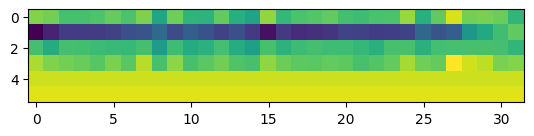

In [10]:
np.random.seed(1000)
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data()
print(X_train.shape, X_test.shape, tf_test.shape)
plt.imshow(X_train[0][0][:])

In [12]:
def train(model_builder, batch_size):
    trainloader = torch.utils.data.DataLoader(CustomImageDataset(X_train, y_train), 
                                              batch_size=batch_size, 
                                              shuffle=True)
    model = model_builder(6).to("cuda")
    # print(summary(model, (1, 6, 32)))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(30):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float().to("cuda"))
            loss = criterion(outputs[:, 0], labels.float().to("cuda"))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        # loss_test = criterion(model(torch.tensor(X_test).float().to("cuda")), 
        #                     torch.tensor(y_test).float().to("cuda"))
        # print(f"[{epoch + 1:03d}, {i + 1:5d}] loss train: {running_loss / (i + 1):.3f} | test: {loss_test / (i + 1):.3f}")
        running_loss = 0.0
    return model

In [13]:
device = "cuda"
nitrers = 40
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_test, tf_test = get_data()
    model = train(Net, 256)
    
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()
    metrics[1, i] = mean_absolute_error(p_test, y_test)
    
    threshold = np.percentile(p_train, 10)
    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
    pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
    gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
    f1_mean = metrics.mean(axis=1, where=metrics!=0)
    pprofs_mean_tot = np.nanmean(pprofs_mean)
    gprofs_mean_tot = np.nanmean(gprofs_mean)
    print("-------------------------------------------------")
    print(gprofs_mean, " -> ", pprofs_mean)
    print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
    print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
# plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
plt.plot([0, 100], [threshold, threshold])

000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 : +576.9 ->  +949.6 OK
000 mae_train: 1.08 mae_test: 1.08
-------------------------------------------------
[         nan          nan 576.91174316]  ->  [        nan         nan 949.5958252]
mae_train: 1.08 mae_test: 1.08 ratio: 1.00
av. profit boost: 0.6459984329444753


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


001 profit M5 :   +0.0 ->    +0.0 --
001 profit M15:   +0.0 ->    +0.0 --
001 profit H1 : +989.7 -> +1427.1 OK
001 mae_train: 1.07 mae_test: 1.10
-------------------------------------------------
[         nan          nan 783.32177734]  ->  [          nan           nan 1188.36126709]
mae_train: 1.08 mae_test: 1.09 ratio: 1.01
av. profit boost: 0.5170793171608042


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


002 profit M5 :   +0.0 ->    +0.0 --
002 profit M15:   +0.0 ->    +0.0 --
002 profit H1 :+1604.0 -> +1695.4 OK
002 mae_train: 1.10 mae_test: 1.07
-------------------------------------------------
[          nan           nan 1056.87736003]  ->  [         nan          nan 1357.3861084]
mae_train: 1.08 mae_test: 1.08 ratio: 1.00
av. profit boost: 0.28433644218189247


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


003 profit M5 :   +0.0 ->    +0.0 --
003 profit M15:   +0.0 ->    +0.0 --
003 profit H1 : +602.4 -> +1067.5 OK
003 mae_train: 1.08 mae_test: 1.10
-------------------------------------------------
[         nan          nan 943.25245667]  ->  [          nan           nan 1284.91531372]
mae_train: 1.08 mae_test: 1.09 ratio: 1.00
av. profit boost: 0.3622178290037498


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


004 profit M5 :   +0.0 ->    +0.0 --
004 profit M15:   +0.0 ->    +0.0 --
004 profit H1 :+1533.1 -> +1920.1 OK
004 mae_train: 1.09 mae_test: 1.08
-------------------------------------------------
[          nan           nan 1061.22061768]  ->  [          nan           nan 1411.95725098]
mae_train: 1.08 mae_test: 1.08 ratio: 1.00
av. profit boost: 0.33050303344929594


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


005 profit M5 :   +0.0 ->    +0.0 --
005 profit M15:   +0.0 ->    +0.0 --
005 profit H1 :+1211.6 -> +1491.8 OK
005 mae_train: 1.08 mae_test: 1.10
-------------------------------------------------
[          nan           nan 1086.28675334]  ->  [          nan           nan 1425.26912435]
mae_train: 1.08 mae_test: 1.09 ratio: 1.00
av. profit boost: 0.3120560662009059


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


006 profit M5 :   +0.0 ->    +0.0 --
006 profit M15:   +0.0 ->    +0.0 --
006 profit H1 : +673.3 ->  +944.3 OK
006 mae_train: 1.07 mae_test: 1.12
-------------------------------------------------
[          nan           nan 1027.28782436]  ->  [         nan          nan 1356.5594308]
mae_train: 1.08 mae_test: 1.09 ratio: 1.01
av. profit boost: 0.3205251718533768


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


007 profit M5 :   +0.0 ->    +0.0 --
007 profit M15:   +0.0 ->    +0.0 --
007 profit H1 :+1511.7 -> +1902.6 OK
007 mae_train: 1.09 mae_test: 1.09
-------------------------------------------------
[          nan           nan 1087.83772278]  ->  [          nan           nan 1424.81262207]
mae_train: 1.08 mae_test: 1.09 ratio: 1.01
av. profit boost: 0.3097657786966273


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


008 profit M5 :   +0.0 ->    +0.0 --
008 profit M15:   +0.0 ->    +0.0 --
008 profit H1 :+2067.0 -> +2280.0 OK
008 mae_train: 1.06 mae_test: 1.17
-------------------------------------------------
[          nan           nan 1196.63906521]  ->  [          nan           nan 1519.82845052]
mae_train: 1.08 mae_test: 1.10 ratio: 1.02
av. profit boost: 0.2700809247362492


/tmp/ipykernel_17878/3589544198.py:28: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/home/andrybin/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_17878/3589544198.py:29: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


KeyboardInterrupt: 

In [209]:
pprofs_mean

array([          nan,           nan, 1262.55725861])

In [157]:
profs_test[p_test<threshold].sum()

-439.66187

In [15]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0074 0.0004 0.0014 0.0009 0.0022 0.0258 0.0007 0.0042 0.0000 0.0000 0.0006 0.0051 0.0244 0.0123 0.0029 0.0005 0.0009 0.0000 0.0019 0.0038 0.0001 0.0000 0.0027 0.0003 0.0008 0.0059 0.0047 0.0146 0.0227 0.0058 0.0061 0.0192 0.0102 0.0252 0.0218 0.1189 0.0129 0.0390 0.0000 0.0092 0.0094 0.1496 0.0610 0.0001 0.0300 0.0015 0.0039 0.0096 0.0095 0.0869 0.0426 0.0008 0.0080 0.0287 0.0008 0.0006 0.0173 0.0058 0.0686 0.0197 0.0011 0.0028 0.0016 0.0018 0.0010 0.0024 0.0009 0.0016 0.0014 0.0017 0.0011 0.0079 0.0011 0.0000 0.0024 0.0010 0.0000


In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction

array([[0.49287947, 0.50712053]])